In [1]:
#Import libraries
import os
import pydicom
import numpy as np
import keras
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

/home/yuan/Software/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#Import own utilities
import net3d_model as model_3d
import preproc
import utils

In [3]:
# Load data and masks as dicom files
data_dir = '../../../data'                   #Please change the path accordingly before make any changes
normalnames = data_dir + '/normal_256auto.txt'
img_dir = data_dir + '/256Auto/images'
msk_dir = data_dir + '/256Auto/masks'

image_name_list, mask_name_list = utils.filter_image(normalnames, img_dir, msk_dir)
  
image_dic_list = [pydicom.read_file(os.path.join(img_dir, filename)) for filename in image_name_list ]
msk_dic_list = [pydicom.read_file(os.path.join(msk_dir, filename)) for filename in mask_name_list ]

# Normalizing images
image_list, msk_list = preproc.normalize(image_dic_list, msk_dic_list)
'''
#Check some layer to see whether the label size makes sense -> makes sense
show = plt.figure()
show.add_subplot(2,2,1)
#plt.imshow(x_list[0][66])
#show.add_subplot(1,2,2)
plt.imshow(image_dic_list[0].pixel_array[77].reshape(256,256))

#plt.imshow(y_list[0][66])
show.add_subplot(2,2,2)
plt.imshow(msk_dic_list[0].pixel_array[77].reshape(256,256))
show.add_subplot(2,2,3)
#plt.imshow(x_list[0][66])
#show.add_subplot(1,2,2)
plt.hist(image_list[0][77].reshape(256,256))

#plt.imshow(y_list[0][66])
show.add_subplot(2,2,4)
plt.hist(msk_list[0][77].reshape(256,256))
'''

'\n#Check some layer to see whether the label size makes sense -> makes sense\nshow = plt.figure()\nshow.add_subplot(2,2,1)\n#plt.imshow(x_list[0][66])\n#show.add_subplot(1,2,2)\nplt.imshow(image_dic_list[0].pixel_array[77].reshape(256,256))\n\n#plt.imshow(y_list[0][66])\nshow.add_subplot(2,2,2)\nplt.imshow(msk_dic_list[0].pixel_array[77].reshape(256,256))\nshow.add_subplot(2,2,3)\n#plt.imshow(x_list[0][66])\n#show.add_subplot(1,2,2)\nplt.hist(image_list[0][77].reshape(256,256))\n\n#plt.imshow(y_list[0][66])\nshow.add_subplot(2,2,4)\nplt.hist(msk_list[0][77].reshape(256,256))\n'

In [4]:
#Make loaded files to patches (both images and masks)

x_list = []
y_list = []
n_slices = 64   #Currently set it to 32 - TBD
for i in range(len(image_list)):
    try:
        n, x_data, y_data = preproc.to3dpatches(image_list[i], msk_list[i], depth = n_slices, size = 64,toBoxes = True)
    except:
        print("Warning: Dismissing one stack")
    else:
        for i in range(n):
            if np.any(y_data[i]):
                x_list.append(x_data[i])
                y_list.append(y_data[i])
    
x_list = np.stack(tuple([x for x in x_list]))[...,np.newaxis]
y_list = np.stack(tuple([y for y in y_list ]))[...,np.newaxis]
print(x_list.shape, y_list.shape)

[40, 89]
[14, 90]
[4, 72]
[0, 117]
[21, 91]
[15, 78]
[49, 84]
[71, 108]
[29, 87]
[49, 125]
Very likely to contain zero information in the labelled data
[24, 147]
[82, 140]
[12, 83]
[78, 150]
[30, 138]
Very likely to contain zero information in the labelled data
(58, 64, 64, 64, 1) (58, 64, 64, 64, 1)


In [5]:
#Only train a little to save time when testing
#x_list = x_list[0:10]
#y_list = y_list[0:10]

In [6]:
n_slices = 64

model, prediction = model_3d.conv_net(size = 64, activation_type = "sigmoid", n_slices = n_slices, depth = 5, n_base_filters = 16)

In [7]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              (None, 64, 64, 64, 1 0                                            
__________________________________________________________________________________________________
conv3d_1 (Conv3D)               (None, 64, 64, 64, 1 448         image[0][0]                      
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 64, 64, 64, 1 64          conv3d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 64, 64, 64, 1 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv3d_2 (

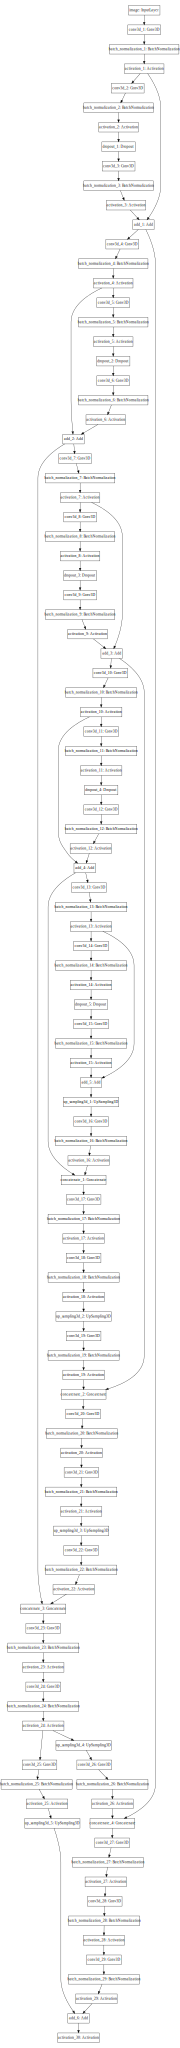

In [8]:
# This visualization might not work depending on how graphviz is installed, but it gives a simple overview of the structure.
#To do: output this image to file or in pop up window
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [9]:
model.compile(loss=model_3d.dice_coef_loss, optimizer='adam', metrics=['acc', model_3d.dice_coef])

In [10]:
#train_seq = image_mask_sequence('data/train', batch_size=10, size=256)
batch_size = 2
test_porpotion = (len(x_list)%batch_size + batch_size)/len(x_list)  #Just for convienient
#test_porpotion = 0.25
#test_porpotion = 0.2
#a small number of prediction images
x_train, x_test, y_train, y_test = train_test_split(x_list, y_list, test_size = test_porpotion, random_state=43)

In [11]:
#Will take a long time
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size = batch_size,
                   epochs=1, verbose=1, shuffle=True)

Train on 56 samples, validate on 2 samples
Epoch 1/1
56/56 [==============================] - 578s 10s/step - loss: 0.9465 - acc: 0.8275 - dice_coef: 0.0535 - val_loss: 0.9562 - val_acc: 0.2917 - val_dice_coef: 0.0438


In [12]:
import matplotlib.pyplot as plt


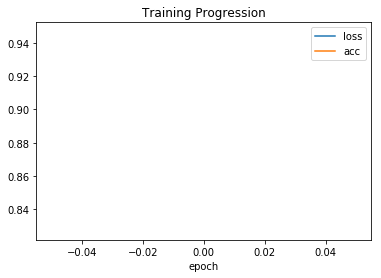

In [13]:
plt.title('Training Progression')
plt.plot(history.epoch, history.history['loss'], label='loss')
plt.plot(history.epoch, history.history['acc'], label='acc')

#plt.plot(history.epoch, history.history[model_3d.dice_coef], label="dice coef")  #TBD
plt.xlabel('epoch')
plt.legend()
plt.show()

In [14]:
n_slice = 64
size = 64

index = 2



#data = utils.padImage(x_list[index])
#data_tobox = preproc.to3dpatches(data, )
predictions = model.predict(x_list[index].reshape(1,n_slice,size,size,1), steps=1)

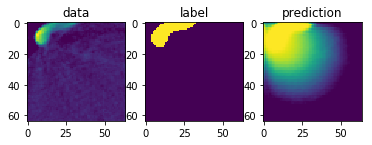

In [15]:
slice_index = 34
#Show original, mask, prediction#Show or 
show = plt.figure()
data = show.add_subplot(1,3,1)
data.set_title("data")
#plt.imshow(x_list[0][66])
plt.imshow(x_list[index][slice_index].reshape(size,size))

label = show.add_subplot(1,3,2)
label.set_title("label")
plt.imshow(y_list[index][slice_index].reshape(size,size))

prediction = show.add_subplot(1,3,3)
prediction.set_title("prediction")
plt.imshow(predictions[0][slice_index].reshape(size,size))



In [22]:
from keras import backend

print(predictions[0][slice_index].shape)

#dice = model_3d.dice_coef(predictions[0],x_list[index])
dice = model_3d.dice_coef(predictions[0],predictions[0])

print(predictions[0][slice_index].dtype)
#dice = dice_coef(y_list[index],predictions[0])
print(dice)
#dice = backend.print_tensor(dice*8, message='y_pred = ')
#backend.print_tensor(dice, message='')
#print(dice)
piece = predictions[0]
piece = piece[piece > 0.9]
dice = model_3d.dice_coef(piece,piece)

backend.eval(dice)


(64, 64, 1)
float32
Tensor("truediv_7:0", shape=(), dtype=float32)


0.9700479